# Pneumonia Detection From X-Rays
In this notebook, we build a binary classifier that tells us whether a patient has pneumonia, based on a chest X-ray of the patient.
By doing so, we solve [this](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) Kaggle challenge.
We use convolutional neural networks and get an AUC of 95% on the test dataset. The [best](link?) participant of the Kaggle challenge got an AUC of ??% (TODO: or accuracy or whatever)

If you have Docker installed, you can play around with this notebook yourself
by following these steps.

- `git clone git@github.com:mojgankamali67/Kaggle.git`
- download the [data](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/download) from kaggle and extract them into the folder `Kaggle/XRay/data`.
This requires a Kaggle account.
- `cd Kaggle/XRay`
- `docker build -t xray .`
- `docker run --rm -p 8888:8888 xray `
- open `localhost:8888/notebooks/Xray.ipynb` in your web browser

We start by loading required packages, in particular `TensorFlow` and `Keras` for our building Convolutional Neural Network (CNN).

In [242]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import random
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight


## Loading the Data

We load our train and test images. Both datasets contain subfolders representing NORMAL and PNEUMONIA images.

In [243]:
train_normal    = Path("data/train/NORMAL").glob('*.jpeg')
train_pneumonia = Path("data/train/PNEUMONIA").glob('*.jpeg')
test_normal     = Path("data/test/NORMAL").glob('*.jpeg')
test_pneumonia  = Path("data/test/PNEUMONIA").glob('*.jpeg')

Image size and number of channels vary between different images. In order to remove such inconsistencies, we write a function `prepare_data` that we apply to all images in the train and test set. This function performs the following modifications:
- sets the number of channels to three
- standardises pixel values to the range [0,1]
- resizes images to 180 x 180
- appends labels 0 (NORMAL) and 1 (PNEUMONIA)

In [244]:
IMAGE_SIZE = [180,180]
def prepare_data(path, case):
    img = tf.io.read_file(str(path))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    if case == "NORMAL":
        return img,0
    if case == "PNEUMONIA":
        return img,1

The training data consists of 5216 images
and the test data consists of 624 images.


In [245]:
zipped_train  = [prepare_data(l, 'NORMAL') for l in train_normal]
zipped_train += [prepare_data(l, 'PNEUMONIA') for l in train_pneumonia]
x_train,y_train = zip(*zipped_train)

zipped_test  = [prepare_data(l, 'NORMAL') for l in test_normal]
zipped_test += [prepare_data(l, 'PNEUMONIA') for l in test_pneumonia]
x_test,y_test = zip(*zipped_test)
print("size of train set: {}, size of test set: {}".format(len(x_train), len(x_test)))

size of train set: 5216, size of test set: 624


We see that both the trainig and test data is unbalanced. In the training set, the number of PNEUMONIA cases are almost three times as high as the number of NORMAL cases.

NORMAL: 1341, PNEUMONIA: 3875


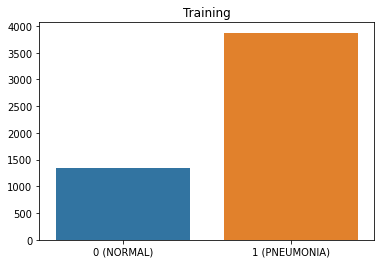

In [246]:
indices, counts = np.unique(y_train, return_counts=True)
sns.barplot(x=[str(indices[0])+" (NORMAL)", str(indices[1])+" (PNEUMONIA)"], y = counts).set_title("Training")
print("NORMAL: {}, PNEUMONIA: {}".format(*counts))


NORMAL: 234, PNEUMONIA: 390


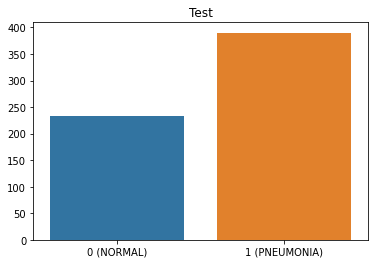

In [247]:
indices, counts = np.unique(y_test, return_counts=True)
sns.barplot(x=[str(indices[0])+" (NORMAL)", str(indices[1])+" (PNEUMONIA)"], y = counts).set_title("Test")
print("NORMAL: {}, PNEUMONIA: {}".format(*counts))

We visualise some of the training images (both for NORMAL and PNEUMONIA cases). We notice that pneumonia images tend to have white spots in the lung region. Nevertheless, for the layman it is quite hard to distinguish between normal and pneumonia images. Let's hope our network can do a better job.

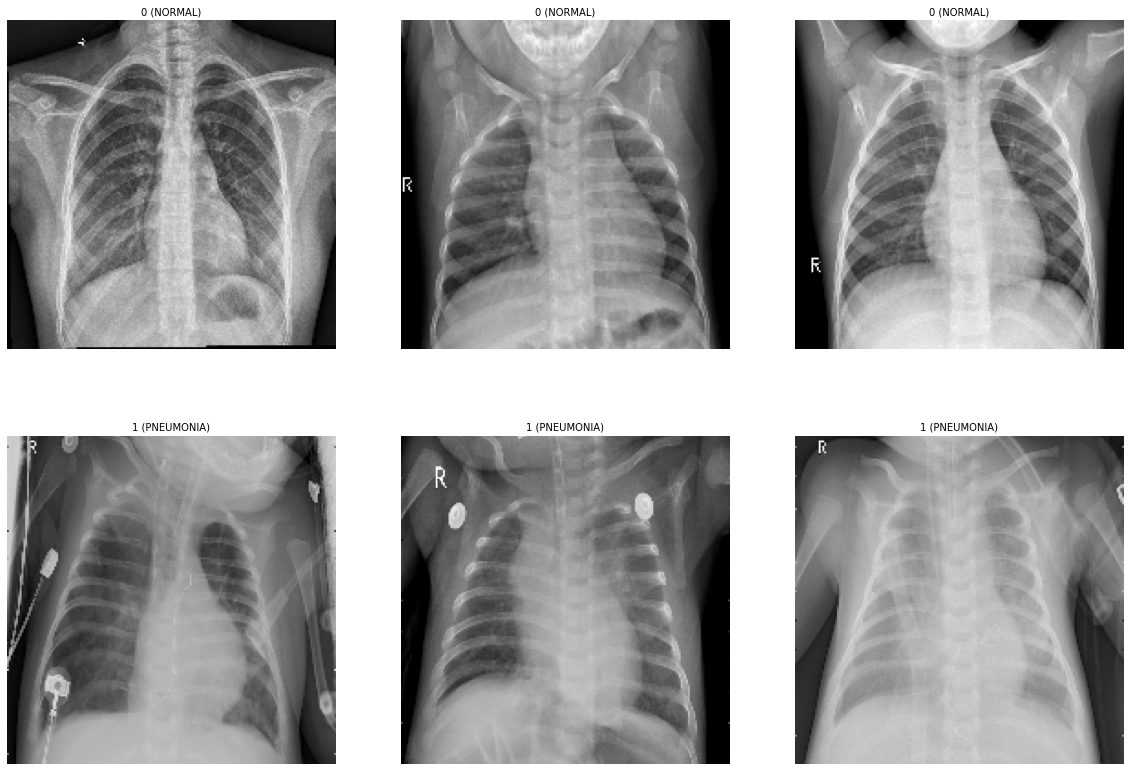

In [248]:
normal_img = []
pneumonia_img = []
for i in range(len(y_train)):
    if y_train[i]==0 and len(normal_img)<3:
        normal_img.append((x_train[i], '0 (NORMAL)'))
    elif y_train[i]==1 and len(pneumonia_img)<3:
        pneumonia_img.append((x_train[i], '1 (PNEUMONIA)'))
    if len(normal_img) >= 3 and len(pneumonia_img) >= 3:
        break
imgs = normal_img + pneumonia_img
fig= plt.figure(figsize=(20, 14))
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    img = plt.imshow(imgs[i][0])
    plt.title(str(imgs[i][1]),size=10)
    plt.axis('off')
plt.show()


We convert our images into numpy arrays so that they can be consumed by keras and check their shapes.

In [249]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test:  ", x_test.shape)
print("y_test:  ", y_test.shape)

x_train:  (5216, 180, 180, 3)
y_train:  (5216,)
x_test:   (624, 180, 180, 3)
y_test:   (624,)


We artificially expand the variety of our training set using data augmentation. We use random image rotation by 30 degrees, zooming by 20% and horizontal fliping. 


In [375]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range = 30,                  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2,                     # Randomly zoom image 
        #width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
        #height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,               # randomly flip images
        vertical_flip=False)
        
data_augmentation.fit(x_train)

## Constructing our Model

We define a simple convolutional model consisting of four convolutional layers with max pooling,
followed by two fully connected layer.
For regularization, we add a dropout layer before the last fully connected layer.
The whole model has 21,195 parameters.

In [386]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 178, 178, 2)       56        
_________________________________________________________________
batch_normalization_102 (Bat (None, 178, 178, 2)       8         
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 89, 89, 2)         0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 87, 87, 2)         38        
_________________________________________________________________
batch_normalization_103 (Bat (None, 87, 87, 2)         8         
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 43, 43, 2)         0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 41, 41, 2)       

We train our network for 30 epochs with a batch size of 32. Since the data is imbalanced, we not only check `accuracy`, but also `precision`, `recall` and `auc` (area under curve). 
We use the `adam` optimiser, and because we are dealing with a binary classification problem (NORMAL or PNEUMONIA), we use `binary_crossentropy` loss. 
A callback reduces the learning rate as soon as the precision does not decrease for two rounds.
As soon as it does not decrease for ten rounds, `early_stopping` is used to stop the training altogether.
At last, `model_checkpoint` stores the best model, so we can use it later.

In [387]:
BATCH_SIZE = 32
EPOCHS = 20
 
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name = 'auc')]
    )

early_stopping   = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience =15)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
learning_rate    = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.3)

Furthermore, we use class weights to give more weight to our minority class 0 (NORMAL) when calculating the loss. 

In [388]:
weight_for_0, weight_for_1 = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


Now we finally train our model and evaluate it on our test set.

In [389]:
history = model.fit(data_augmentation.flow(x_train,y_train, batch_size = BATCH_SIZE), 
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    class_weight=class_weight,
    callbacks=[learning_rate],
    verbose = 1
)

Epoch 1/20
163/163 [==============================] - 47s 279ms/step - loss: 0.4889 - accuracy: 0.7320 - precision: 0.9155 - recall: 0.7016 - auc: 0.8247 - val_loss: 1.9907 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000 - val_auc: 0.6244
Epoch 2/20
163/163 [==============================] - 46s 283ms/step - loss: 0.2991 - accuracy: 0.8667 - precision: 0.9700 - recall: 0.8447 - auc: 0.9383 - val_loss: 2.4284 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/20
163/163 [==============================] - 46s 281ms/step - loss: 0.2972 - accuracy: 0.8633 - precision: 0.9630 - recall: 0.8486 - auc: 0.9416 - val_loss: 1.8148 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000 - val_auc: 0.7672
Epoch 4/20
163/163 [==============================] - 45s 275ms/step - loss: 0.2861 - accuracy: 0.8685 - precision: 0.9752 - recall: 0.8461 - auc: 0.9468 - val_loss: 0.3503 - val_accuracy: 0.8494 - val_precision: 0.8737 - v

We check the classification report, including `precision`, `recall` and `F1-score` and `accuracy`
and notice that our model can distinguish with good confidence between pneumonia and normal images.
`Precision` is the percentage of predicted positives that were correctly classified and `recall` is the percentage of actual positives that were correctly classified. `AUC` refers to the area under the curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.



In [390]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.80      0.88      0.84       234
Pneumonia (Class 1)       0.92      0.87      0.89       390

           accuracy                           0.87       624
          macro avg       0.86      0.87      0.86       624
       weighted avg       0.87      0.87      0.87       624



The `confusion_matrix` shows the number of correctly/incorrectly classified instances (TN = 205, FP = 29, FN = 52, TP = 338) where negatives cases are NORMAL(0) and positive cases are PNEUMONIA (1). This means that our classifier has correctly classified 205 normal cases and 338 pneumonia cases. However, 29 normal cases were misclassified as pneumonia and 52 pneumonia cases were misclassified as normal.

NORMAL: 234, PNEUMONIA: 390


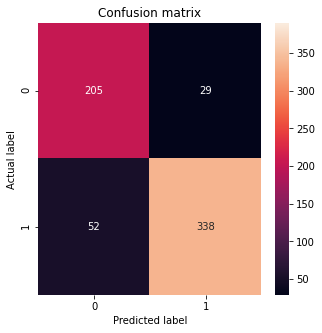

In [391]:
plt.figure(figsize=(5,5))
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", vmax = counts[1])
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("NORMAL: {}, PNEUMONIA: {}".format(*counts))

We calculate the value of AUC (showing how skilled our model is in distinguishing between different classes) and plot the  Receiver Operating Characteristic (ROC) curve. ROC is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0.

In [405]:
pred_prob = model.predict_proba(x_test)
pred_prob = pred_prob.reshape(1,-1)[0]
fpr, tpr, thresh = roc_curve(y_test, pred_prob, pos_label=1)
auc_score = roc_auc_score(y_test, pred_prob)
print('AUC_score :{:.2f}'.format(auc_score))

AUC_score :0.95


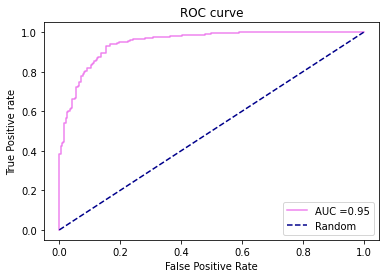

In [406]:
plt.plot(fpr, tpr, color='violet')
plt.plot([0,1],[0,1], color='darkblue', linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(['AUC =' + str('{:.2f}'.format(auc_score)), 'Random'])
plt.show()

Finally, let us check how the model performance changed during training. 
- Figure `Model precision` shows an upwarding trend for both traing and test sets.
- Figure `Model recall` shows an upwarding trend for the train set and a downwarding trend for the test set.
- Figure `Model accuracy` shows an upwarding trend for both traing and test sets.
- Figure `Model loss` shows a downwarding trend for both traing and test sets.
- Figure `Model auc` shows an upwarding trend for both traing and test sets.

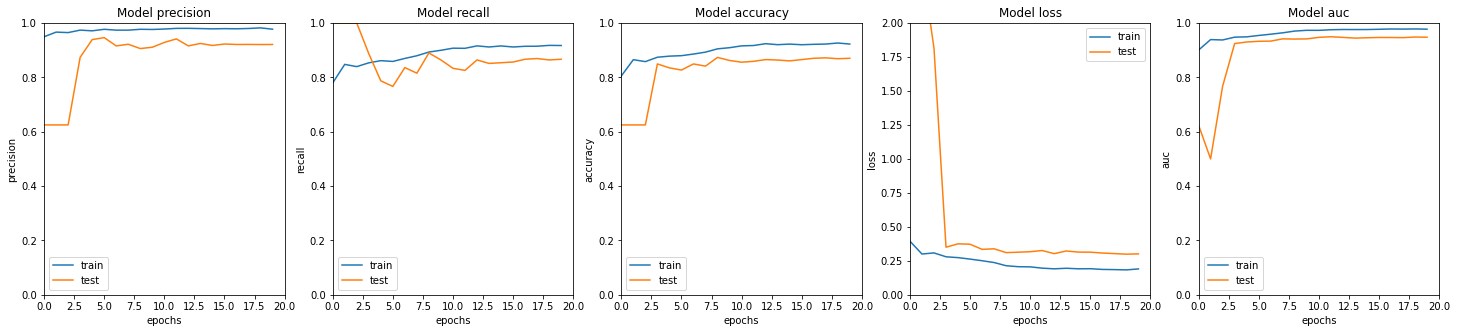

In [407]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))    

ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss', 'auc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'test'])
    ax[i].set_xlim([0, EPOCHS])
    ax[i].set_ylim([0, 1])
    if met == 'loss':
        ax[i].set_ylim([0, 2])





In the future, one may perform a grid search to find better hyperparameters or increase the size of the model to get even better results.

## Notes

In [408]:
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,